# Imports

In [57]:
import time
import os
import pickle
import inspect
import numpy as np
from importlib import reload
from common import numerics as num
from common import numerical_recipes as numrec
from common.baseclasses import AWA

import FenicsTools as FT #I use a periodic boundary condition helper from here
from matplotlib import pyplot as plt
from dolfin import *
from scipy.interpolate import RectBivariateSpline as RBS

import BokehPlasmons
from BokehPlasmons import tip_modeling as TM
base_dir=os.path.dirname(os.path.dirname(inspect.getfile(TM)))
demo_dir=os.path.join(base_dir,'demos')
conductivites_dir=os.path.join(demo_dir,'conductivities')
eigenbases_dir=os.path.join(demo_dir,'eigenbases')

# Mesh for Fenics

In [ ]:
Neigenfunctions=1000 #number of sample eigenfunctions to compute

# Create mesh for fenics
Nin=200 #number of xy pixels for fenics
xspan = 200 #fenics simulation size in nm
mesh = RectangleMesh(Point(-xspan/2, -xspan/2),\
                     Point(xspan/2, xspan/2),\
                     Nin, Nin, diagonal='crossed')
#mesh = UnitSquareMesh(Nin, Nin, 'crossed')

# Inhomogeneous conductivity

## User-defined profile

<IPython.core.display.Javascript object>


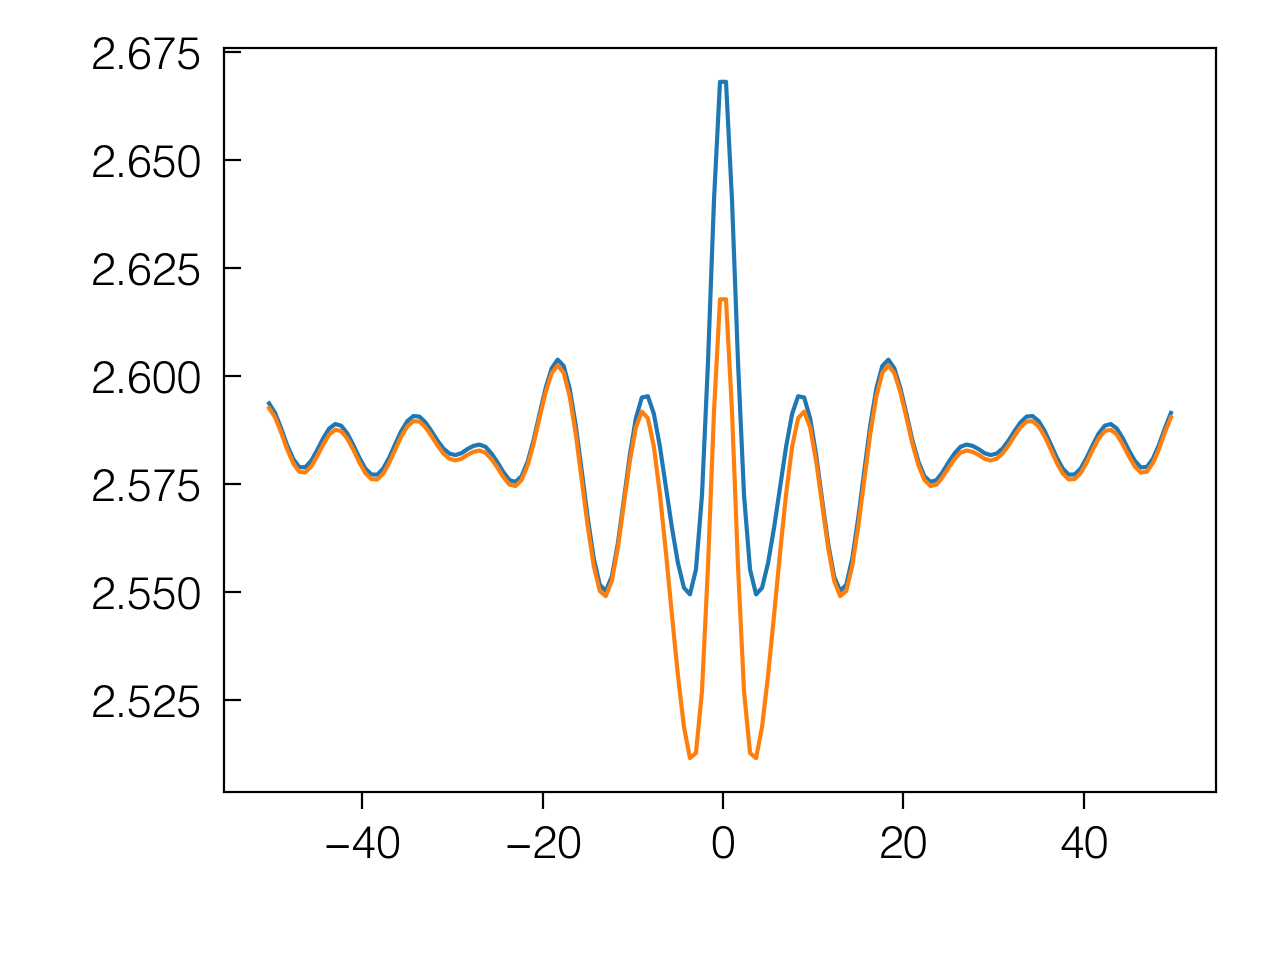

<IPython.core.display.Javascript object>


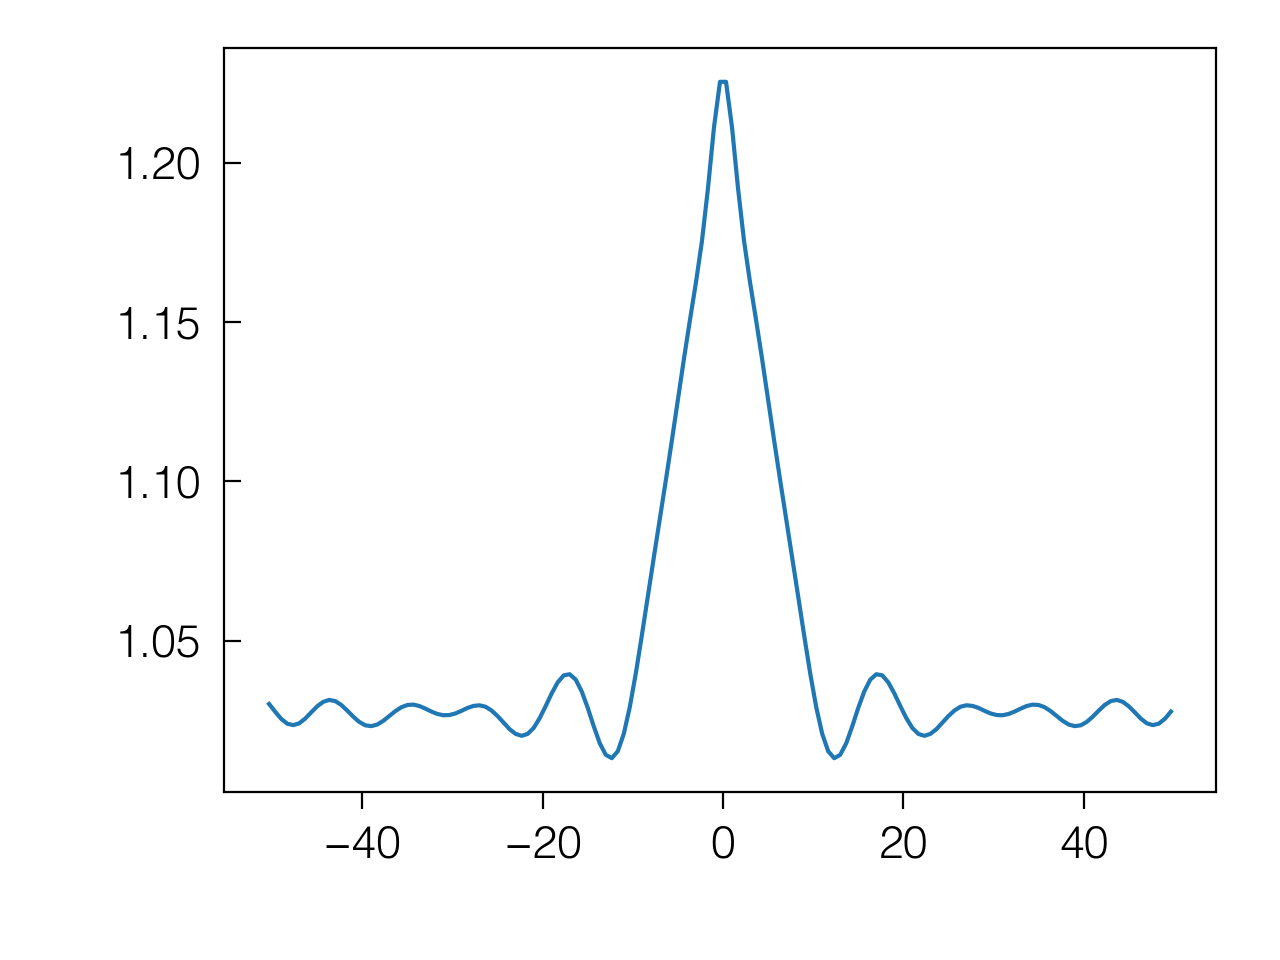

In [58]:
file_path=os.path.join(conductivites_dir,'DW_sigma_w1500mu0.006Vi0.002g0.25.txt')

xs,sigma_xx,sigma_yy=np.loadtxt(file_path,delimiter=',',dtype=complex).T
xs=xs.astype(float)
plt.plot(xs,sigma_xx.real); plt.plot(xs,sigma_xx.imag,color=plt.gca().lines[-1].get_color(),ls='--'); 
plt.plot(xs,sigma_yy.real); plt.plot(xs,sigma_yy.imag,color=plt.gca().lines[-1].get_color(),ls='--');

plt.figure()
plt.plot(xs,np.abs(sigma_xx))
plt.plot(xs,np.abs(sigma_xx.real))

from scipy.interpolate import interp1d
sigma_norm=(np.abs(sigma_xx-sigma_xx.imag)/np.abs(sigma_xx[-1])).astype(float)
#xs_norm=((xs-xs.min())/(xs.max()-xs.min())).astype(float)
sigma_norm=1+(sigma_norm-1)*1
interp=interp1d(xs,sigma_norm,\
                bounds_error=False,fill_value=sigma_norm[0])
sigma_func=lambda x,y: interp(x)

#plt.figure(); plt.plot(xs_norm,sigma_func(xs_norm,0))
plt.figure(); plt.plot(xs,sigma_func(xs,0))

## Verify conductivity function

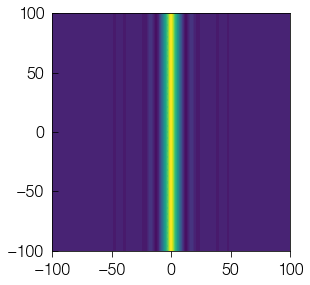

In [54]:
#ASM 2020.04.23: All this machinery now exists in William's code somewhere?
def reorder(array,new_order):
    new_array = np.zeros(len(array))
    new_array[new_order]=array
    
    return new_array

V = FunctionSpace(mesh, "Lagrange", 1)

f_sigma = Function(V)
sigma = [sigma_func(coords[0],coords[1]).squeeze() for coords in mesh.coordinates()]
sigma = reorder(sigma,vertex_to_dof_map(V))
f_sigma.vector().set_local(sigma)
plot(f_sigma)

# Fenics eigensolver

In [55]:
eigenvalue=0
number_extracted=Neigenfunctions
periodic_boundary=True

# log info here: https://fenicsproject.org/qa/810/how-to-disable-message-solving-linear-variational-problem/
PROGRESS=16
set_log_level(PROGRESS)
set_log_active(True)

if periodic_boundary: CD=FT.PeriodicBoundary2D(mesh)
else: CD=None

P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
R = FiniteElement("Real", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, P1 * R, constrained_domain=CD)
V = FunctionSpace(mesh, "Lagrange", 1)

f_sigma = Function(V)
sigma = [sigma_func(coords[0],coords[1]).squeeze() for coords in mesh.coordinates()]
sigma = reorder(sigma,vertex_to_dof_map(V))
f_sigma.vector().set_local(sigma)

(u, c) = TrialFunction(W)
(v, d) = TestFunctions(W)

# f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=2)

#define problem
a = (f_sigma*inner(grad(u), grad(v)) \
     + u*v + c*v + u*d)*dx
m = u*v*dx

#We relax neumann condition if periodic boundaries are enabled
if periodic_boundary:
    n = FacetNormal(mesh)
    #a+= inner(n,f_sigma*grad(u))*v*ds

A = PETScMatrix()
M = PETScMatrix()
_ = PETScVector()
L = Constant(0.)*v*dx

assemble_system(a, L, A_tensor=A, b_tensor=_)
assemble_system(m, L, A_tensor=M, b_tensor=_)

#create eigensolver
eigensolver = SLEPcEigenSolver(A,M)
eigensolver.parameters['spectrum'] = 'target real'
eigensolver.parameters['tolerance'] = 1.e-15
eigensolver.parameters["spectral_transform"] = "shift-and-invert"
eigensolver.parameters["spectral_shift"] = float(eigenvalue) # Could be a possible spot for overflow

#solve for eigenvalues
eigensolver.solve(number_extracted)

assert eigensolver.get_number_converged() > 0

eigenvalues = []
eigenfunctions = []

for i in range(number_extracted):
    u=Function(W)
    
    r, c, rx, cx = eigensolver.get_eigenpair(i)
    
    #assign eigenvector to function
    u.vector()[:] = rx
    eigenvalues.append(r)
    a,b = u.split()
    eigenfunctions.append(project(a,V))

output = dict(list(zip(eigenvalues,eigenfunctions)))

In [67]:
eigensolver.get_eigenpair?

# Process and visualize eigenbasis

In [56]:
from scipy import interpolate

class fenicsFuncToGridInterpolator(interpolate.LinearNDInterpolator):

    def __init__(self,func,dof_mapping=None):
    
        self.load_points(func)
        self.load_values(func,dof_mapping)
        
        super().__init__(self.points,self.values.squeeze(),fill_value=0)
        
    def load_points(self,func):
        
        V=func.function_space()
        mesh=V.mesh()
        self.points=mesh.coordinates()
        
    def load_values(self,func,dof_mapping=None):
        
        V=func.function_space()
        if dof_mapping is None: self.dof_mapping=dof_to_vertex_map(V)
        else: self.dof_mapping=dof_mapping
        zs=func.vector().get_local()
        self.values=reorder(zs,self.dof_mapping)
        self.values.resize((len(zs),1))

In [57]:
Nout=200 #Number of x/y-pixels in the output mesh
spacer=0 #In case we want to zero-pad with some spacer around the sample geometry

dx=xspan/Nout
xmin=-xspan/2.
xmax=xmin+(Nout-1)*dx #This is so that we don't double-count the boundary
Xs,Ys=np.ogrid[-spacer+xmin:xmax+spacer:Nout*1j,\
               -spacer+xmin:xmax+spacer:Nout*1j]
xs,ys=Xs.squeeze(),Ys.squeeze()

Nmax=np.inf
i=0
eigpairs={}
t0=time.time()
for eigval, eigfunc in output.items():
    print(i)
    #if not eigval>2: continue
    if i==0: Interpolator=fenicsFuncToGridInterpolator(eigfunc)
    else: Interpolator.load_values(eigfunc)
    eigpairs[eigval]=AWA(Interpolator(Xs,Ys),axes=[xs,ys])
    i+=1
    if i>Nmax: break
    
print('Processing time per function: %s'%((time.time()-t0)/i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


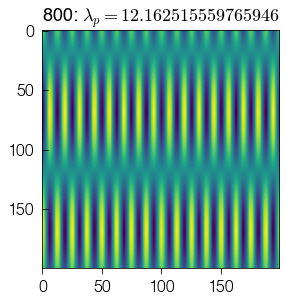

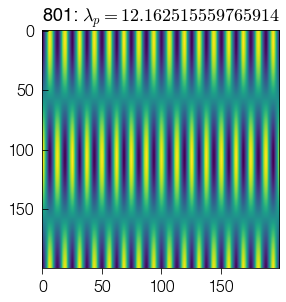

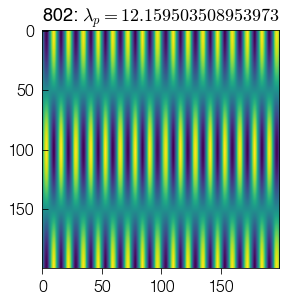

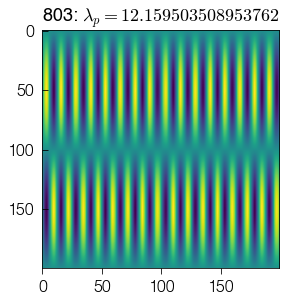

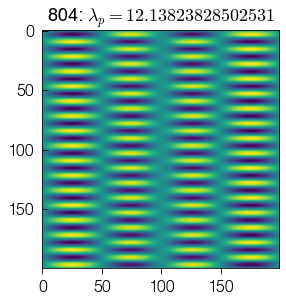

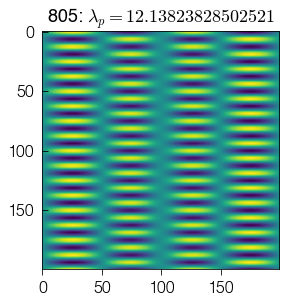

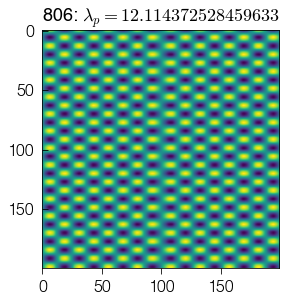

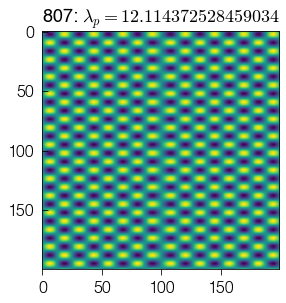

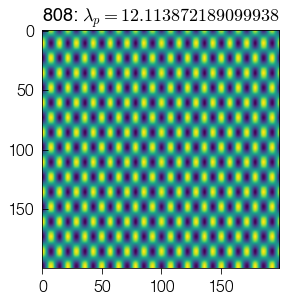

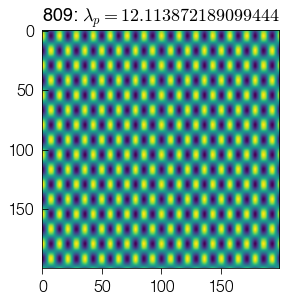

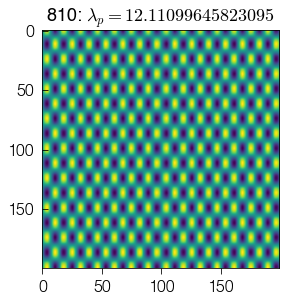

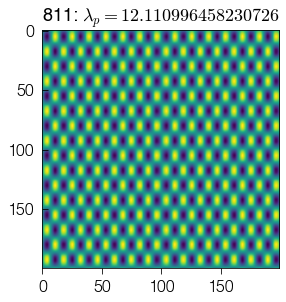

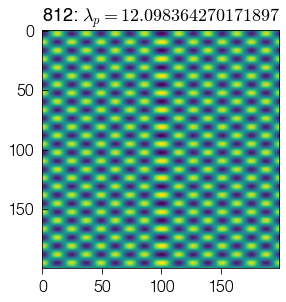

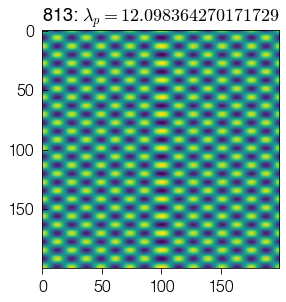

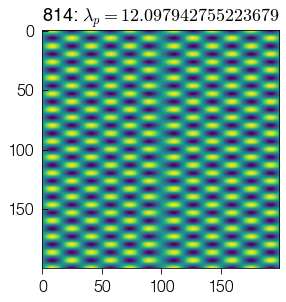

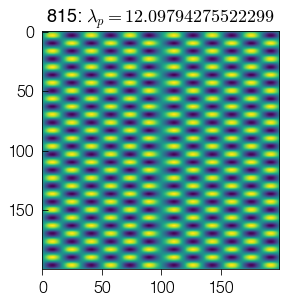

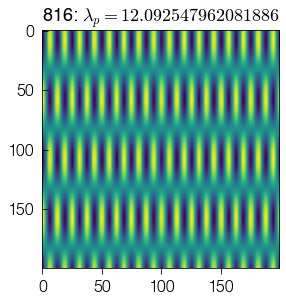

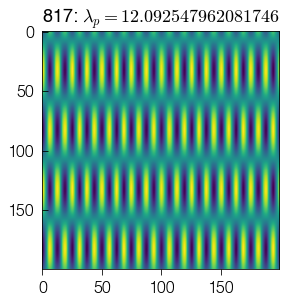

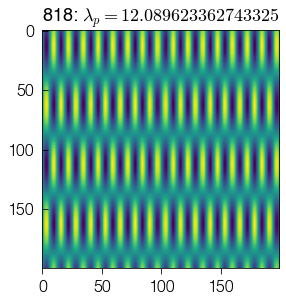

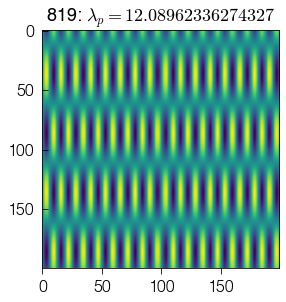

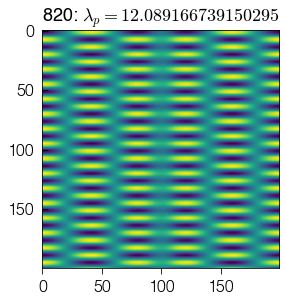

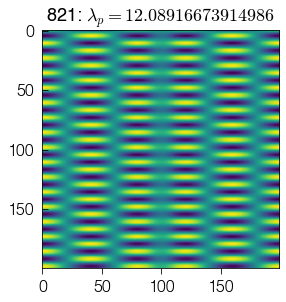

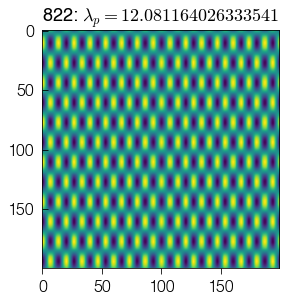

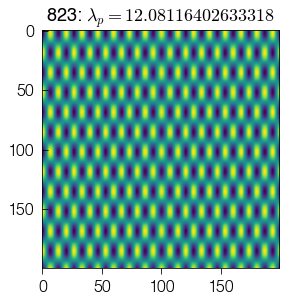

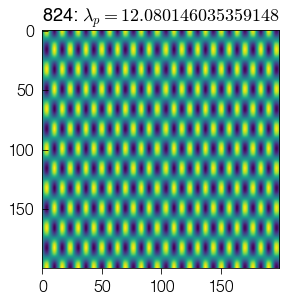

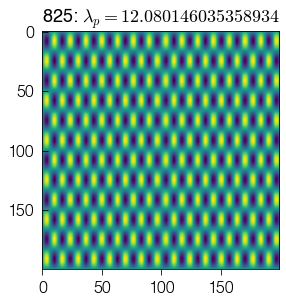

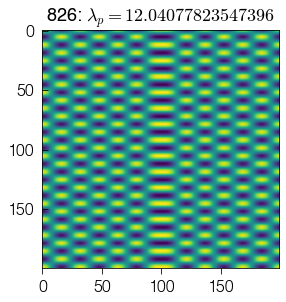

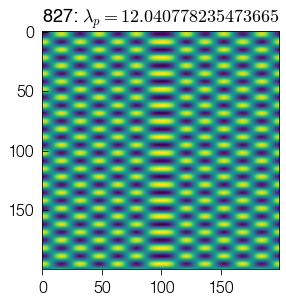

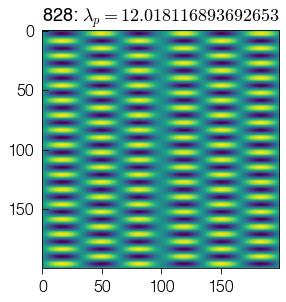

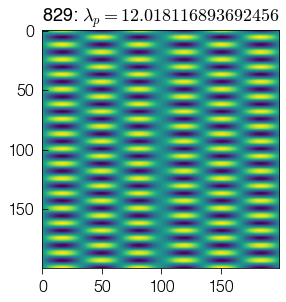

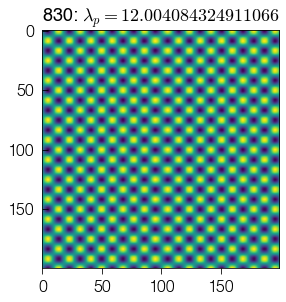

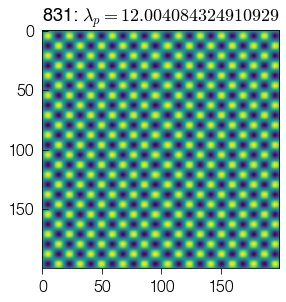

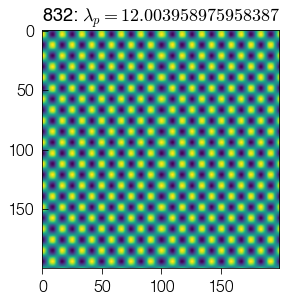

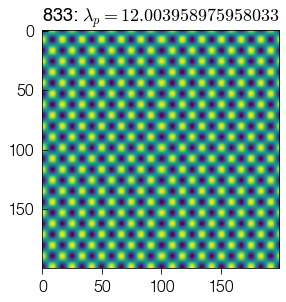

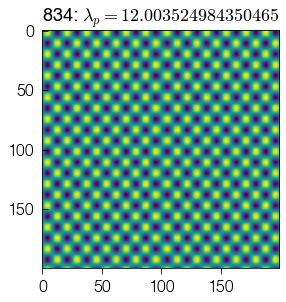

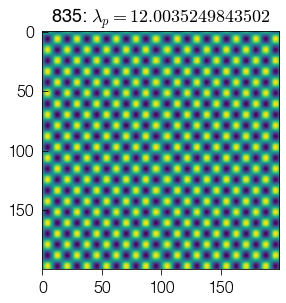

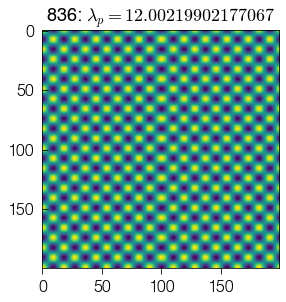

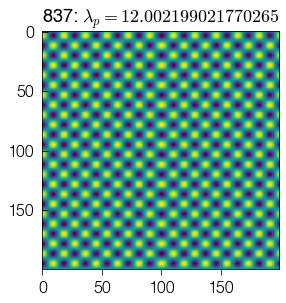

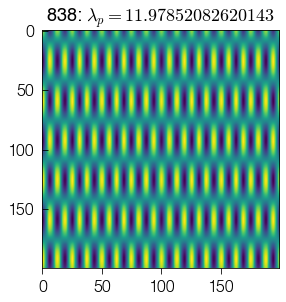

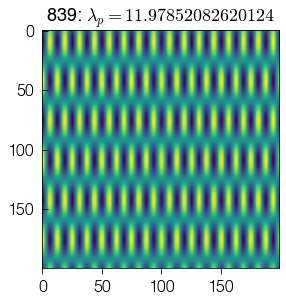

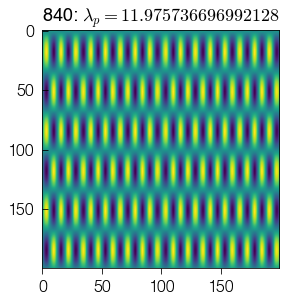

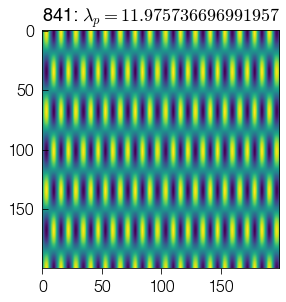

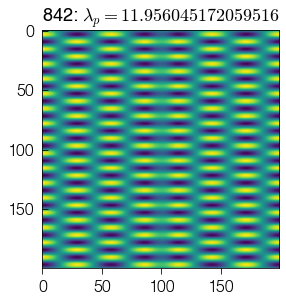

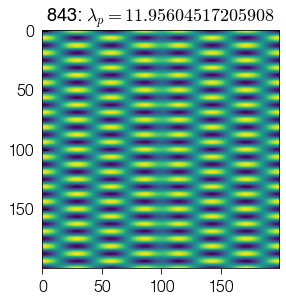

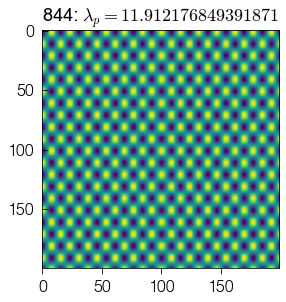

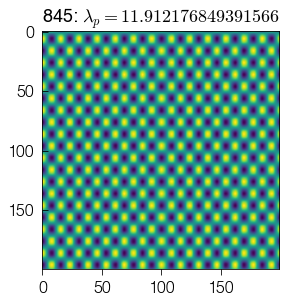

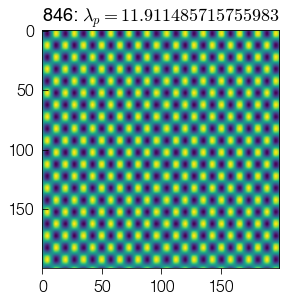

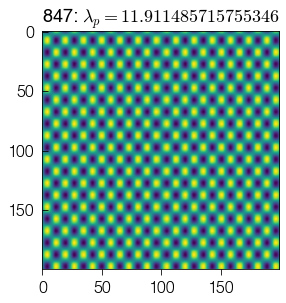

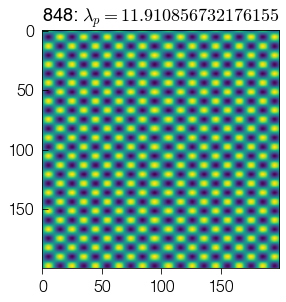

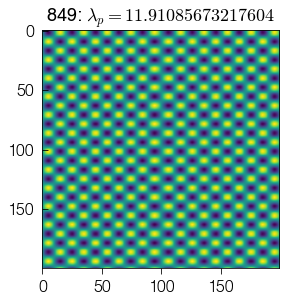

In [79]:
nmin=800
nmax=850

keys=sorted(eigpairs.keys())

for i,key in enumerate(keys[nmin:nmax]):
    func=eigpairs[key]
    plt.figure();plt.imshow(func.T);
    plt.title(r'%i: $\lambda_p=%1.2f$'%(nmin+i,2*np.pi/np.sqrt(key-1.000)))

# Save eigenbasis

In [60]:
filename='Eigenbasis_SaiConductivity_xy%ix%i_NxNy%ix%i_Nq=%i.pickle'%\
          (xspan,xspan,Nout,Nout,number_extracted)
filepath=os.path.join(eigenbases_dir,filename)
with open(filepath,'wb') as f:
    pickle.dump(eigpairs,f)
print('File "%s" written!'%filename)


File "Eigenbasis_SaiConductivity_xy200x200_NxNy200x200_Nq=1000.pickle" written!


# Visualize eigenbasis with some 3D tools

In [63]:
# Load the generated eigenpairs for sample
filename='Eigenbasis_SaiConductivity_xy200x200_NxNy200x200_Nq=1000.pickle'
filepath=os.path.join(eigenbases_dir,filename)
with open(filepath,'rb') as f:
    eigpairs=pickle.load(f)
keys=sorted(eigpairs.keys())

<IPython.core.display.Javascript object>


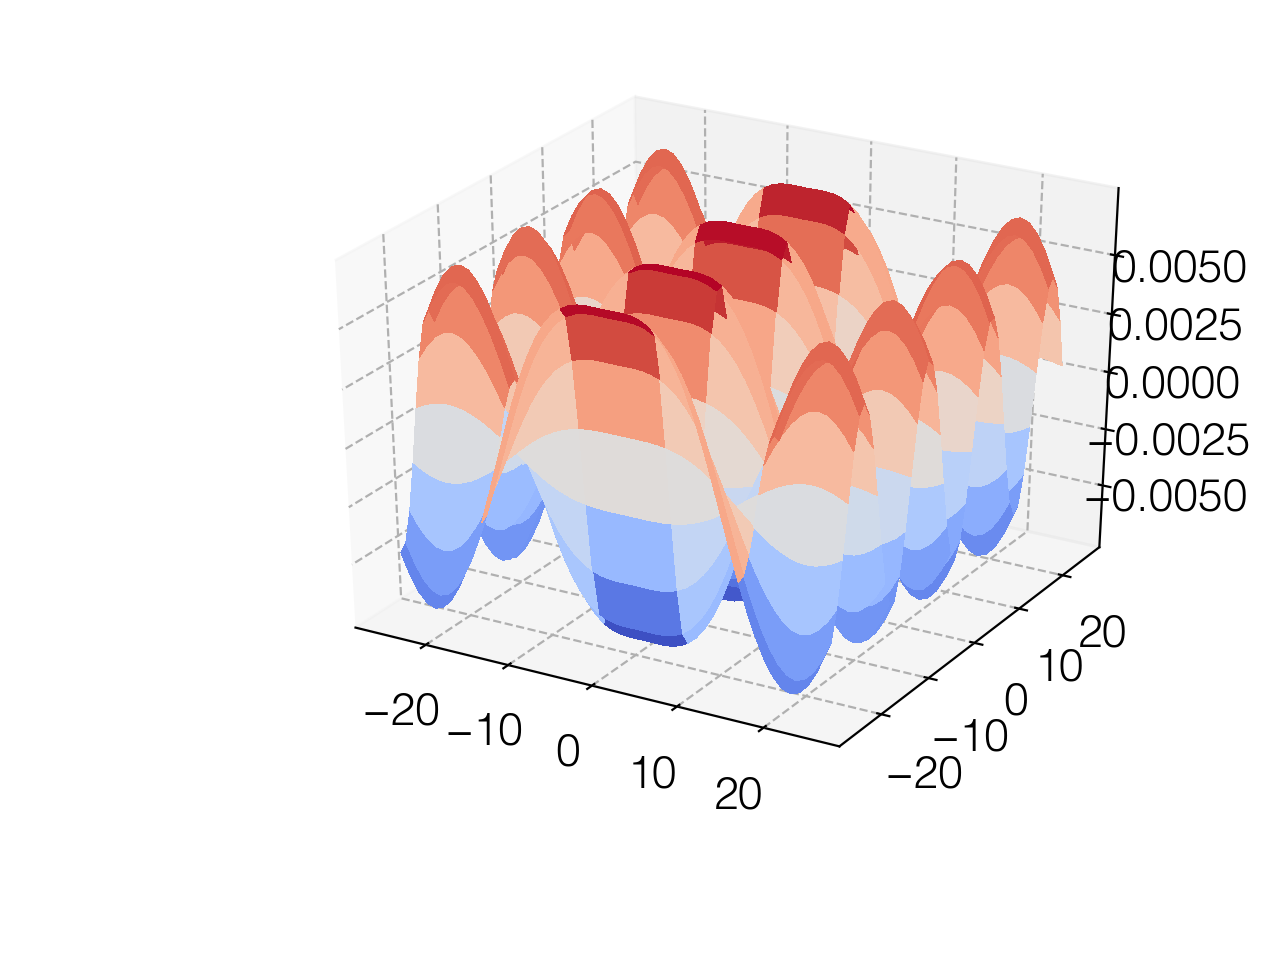

In [64]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

key=keys[827]
Z=eigpairs[key].cslice[-25:25,-25:25]
cstride=(np.max(Z)-np.min(Z))/100
X,Y=Z.axis_grids
ax.plot_surface(X, Y, Z,cmap=cm.coolwarm,
                cstride=1,
                linewidth=0, antialiased=False)

In [65]:
import plotly as py
import plotly.graph_objects as go

key=keys[827]
potential=eigpairs[key].cslice[-25:25,-25:25]

# `potential` is an AWA
Z=potential
X,Y=Z.axis_grids

surface = go.Surface(x=X, y=Y, z=Z)
data = [surface]

layout = go.Layout(
    title='Surface plot: potential',
    scene=dict(
        xaxis=dict(
            visible=False
        ),
        yaxis=dict(
            visible=False,
        ),
        zaxis=dict(
            visible=False,
        ),
        aspectratio = dict(x = 1, y = 1, z = 0.2)
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

# Tip modeling with this sample

<IPython.core.display.Javascript object>


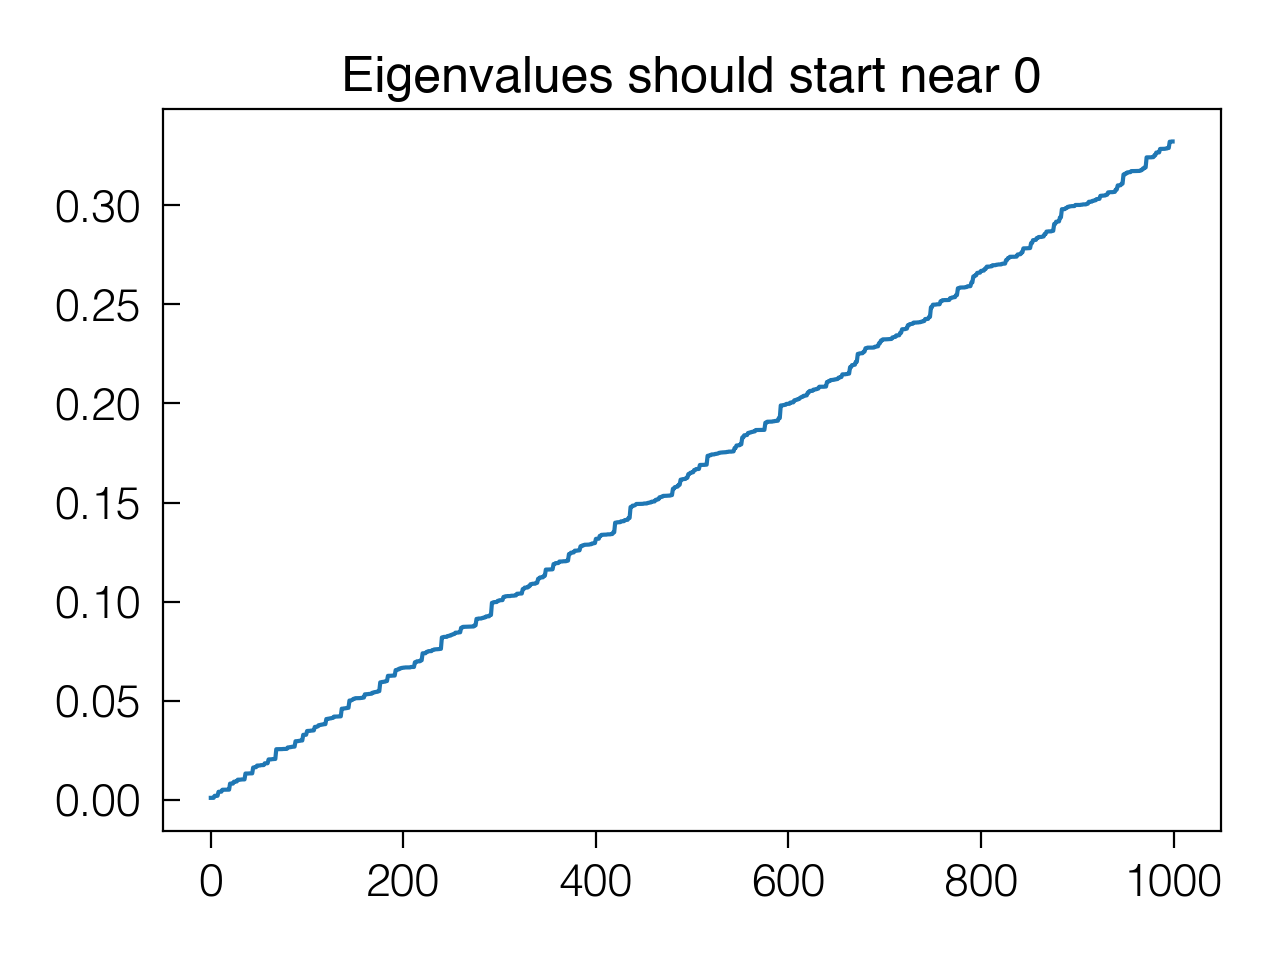

In [66]:
# Load the generated eigenpairs for sample
filename='Eigenbasis_SaiConductivity_xy200x200_NxNy200x200_Nq=1000.pickle'
filepath=os.path.join(eigenbases_dir,filename)
with open(filepath,'rb') as f:
    eigpairs=pickle.load(f)

#ASM 2020.04.23: Correct the eigenvalues, somehow they're all offset by 1??
eigpairs_correct={}
for eigval in eigpairs:
    eigval_correct=eigval-1 
    eigpairs_correct[eigval_correct]=eigpairs[eigval]
    
plt.figure()
plt.plot(sorted(eigpairs_correct.keys()))
plt.title('Eigenvalues should start near 0')
plt.tight_layout()

In [67]:
#Use the generated eigpairs
# With 'periodic' Coulomb, calculation is fast enough to not require multiprocessing
SR=TM.SampleResponse(eigpairs_correct,qp=0,Qfactor=10,N=1000,\
                     coulomb_shortcut=False,coulomb_bc='periodic',\
                     coulomb_multiprocess=False)

#Just our fake tip
tipsize=50
TR=TM.TipResponse(SR.xs,SR.ys,\
                      q=2*np.pi/tipsize,\
                      N_tip_eigenbasis=1,\
                      periodic=True)

def perform_linescans(SR,TR,\
                      lp_min=20,lp_max=100,Nlps=20,\
                       Qfactor=10):
    """
    Perform `Nlps` linescans across the sample while varying
    plasmon wavelength from `lp_min` to `lp_max`.
    """

    SR._set_alpha(Qfactor)
    lps=np.linspace(lp_min,lp_max,Nlps)

    rasters=[]
    for i,lp in enumerate(lps):
        qp=2*np.pi/lp
        SR._set_reflection_matrix(qp)
        rasters.append(SR.raster_scan(TR,ys=0)['R']) #Return reflectance
        print('PROGRESS: %1.1f%% done'%((i+1)/len(lps)*100))
        
    return AWA(rasters,axes=[lps]+rasters[0].axes,\
               axis_names=[r'$\lambda_p$ (nm)','$x$ (nm)'])

Setting Eigenbasis...
	Time elapsed:0.3919069766998291
Tuning Eigenbasis...
	Time elapsed:1.36332106590271
Applying Coulomb kernel...
	Time elapsed:66.1348888874054
Computing Reflection Matrix...
	Time elapsed:0.29624295234680176


In [68]:
linescans=perform_linescans(SR,TR,\
                            lp_min=20,lp_max=100,Nlps=10,Qfactor=2*np.pi)

#Somehow the baseline shifts up and down, correct it
# probably due to periodic boundaries in small simulation cell
for linescan in linescans:
    linescan/=np.mean(linescan)

Computing Reflection Matrix...
	Time elapsed:0.3583800792694092
Raster scanning tip...
	10% complete...
	20% complete...
	30% complete...
	40% complete...
	50% complete...
	60% complete...
	70% complete...
	80% complete...
	90% complete...
	Time elapsed:5.573193073272705
PROGRESS: 10.0% done
Computing Reflection Matrix...
	Time elapsed:0.28214216232299805
Raster scanning tip...
	10% complete...
	20% complete...
	30% complete...
	40% complete...
	50% complete...
	60% complete...
	70% complete...
	80% complete...
	90% complete...
	Time elapsed:5.5835981369018555
PROGRESS: 20.0% done
Computing Reflection Matrix...
	Time elapsed:0.2752358913421631
Raster scanning tip...
	10% complete...
	20% complete...
	30% complete...
	40% complete...
	50% complete...
	60% complete...
	70% complete...
	80% complete...
	90% complete...
	Time elapsed:5.61595606803894
PROGRESS: 30.0% done
Computing Reflection Matrix...
	Time elapsed:0.23827219009399414
Raster scanning tip...
	10% complete...
	20% complete..

<IPython.core.display.Javascript object>


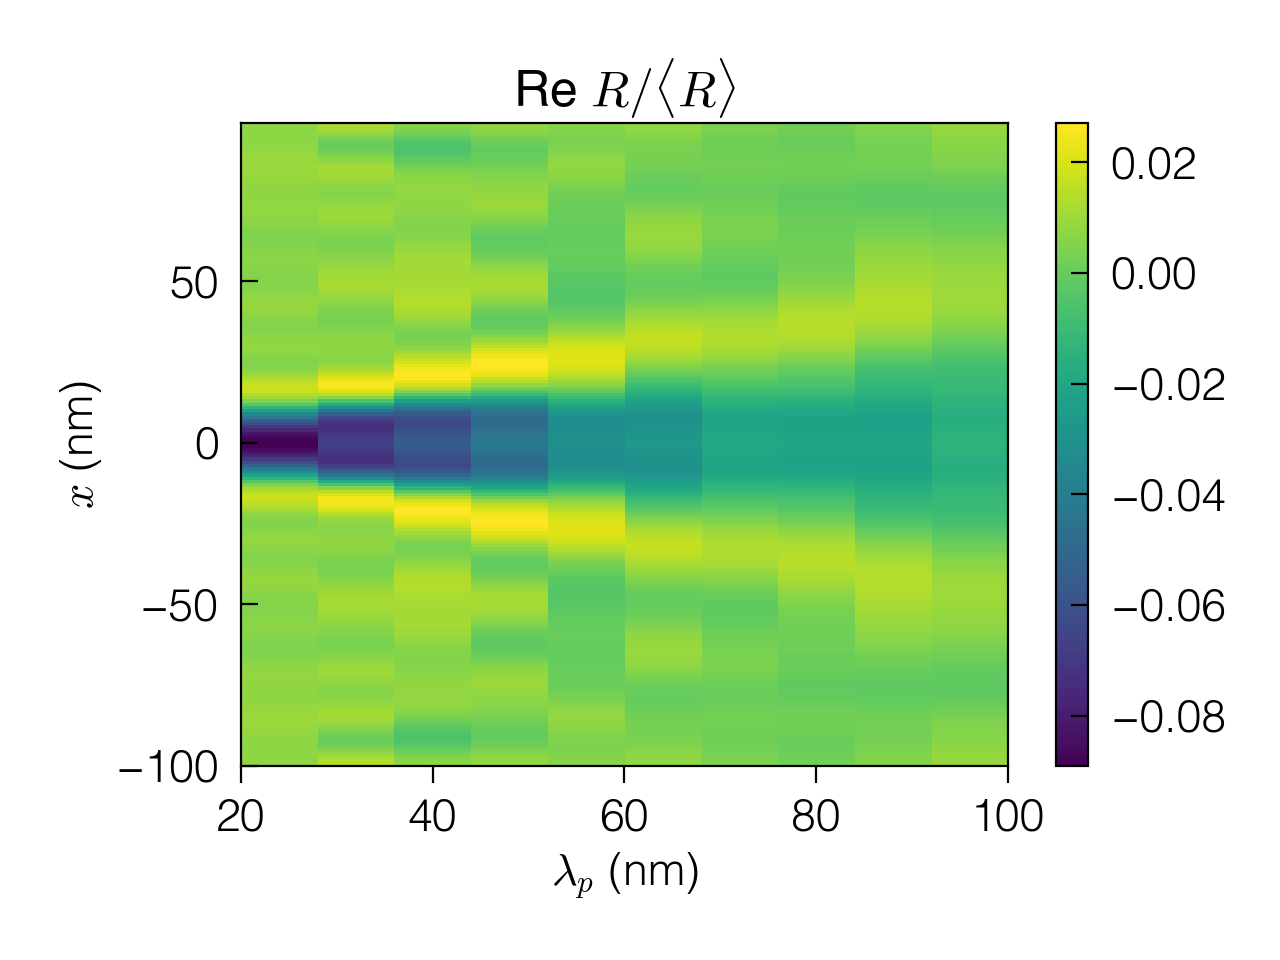

<IPython.core.display.Javascript object>


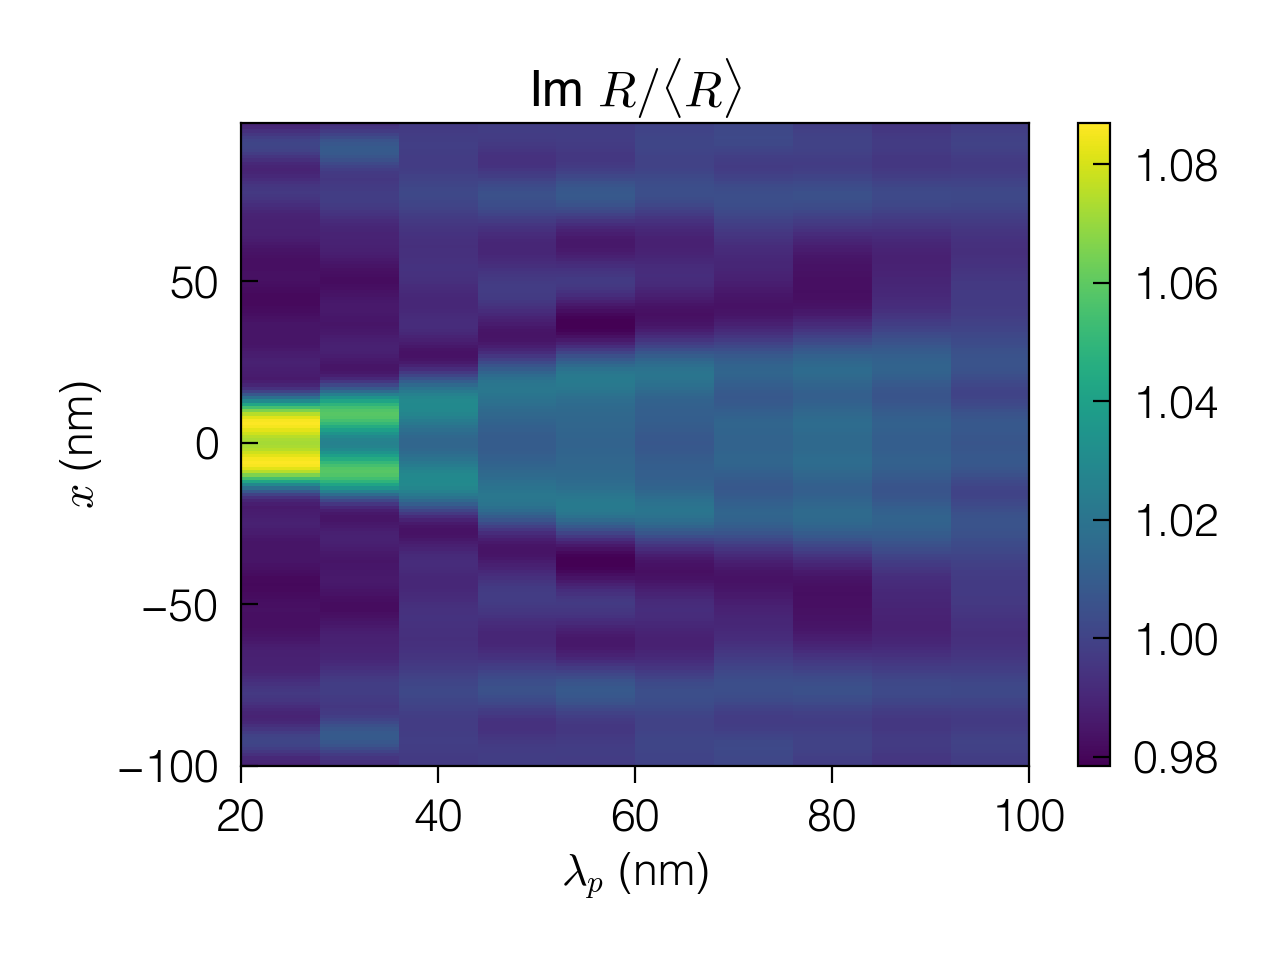

In [69]:
plt.figure()
plt.title(r'Re $R / \langle R \rangle$')
linescans.imag.plot()
plt.tight_layout()

plt.figure()
plt.title(r'Im $R / \langle R \rangle$')
linescans.real.plot()
plt.tight_layout()
